In [1]:
########## Load libraries

import torch as to
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
########### Soft Indexing

L = [[0.2, 0.5, 0.6],
     [0.1, 0.0, 0.45],
     [0.2, 0.7, 0.0]]

M = np.array(L)
SHAPE = (2,2)

print (M)
THRESHOLD_1 = 0.35
args = np.argwhere(M>THRESHOLD_1)
col_idx = np.unique(args[:,0])
row_idx = np.unique(args[:,1])
print ("Undifferentiable spread :", len(col_idx)+len(row_idx))


In [ ]:
SHARPNESS_1 = 50
X = to.tensor(M, dtype=to.float32, requires_grad=True)
mask = to.sigmoid((X - THRESHOLD_1) * SHARPNESS_1)
print (mask)

col_sum = mask.sum(dim=0)
row_sum = mask.sum(dim=1)

THRESHOLD_2 = 0.5
SHARPNESS_2 = 5
cols_idx = to.sigmoid((col_sum - THRESHOLD_2) * SHARPNESS_2)
n_cols = cols_idx.sum()
rows_idx = to.sigmoid((row_sum - THRESHOLD_2) * SHARPNESS_2)
n_rows = rows_idx.sum()
spread = n_cols + n_rows
loss = (spread - SHAPE[0] - SHAPE[1])
print (f"Differentiable spread :", spread)
print (f"Differentiable loss   :", loss)

print (col_sum) # approximation of the amount of items per column / row
print (to.sigmoid((col_sum - THRESHOLD_2) * SHARPNESS_2))
first_col_idx = getFirstIdx(cols_idx)
print ("First col index", first_col_idx)

In [ ]:
def compactness_loss(X, SHAPE, T1, S1, T2, S2): # X 2D
    mask = to.sigmoid((X - T1) * S1)
    col_sum = mask.sum(dim=0)
    row_sum = mask.sum(dim=1)
    n_cols = to.sigmoid((col_sum - T2) * S2).sum()
    n_rows = to.sigmoid((row_sum - T2) * S2).sum()
    spread = n_cols + n_rows
    loss = (spread - SHAPE[0] - SHAPE[1])
    return loss

In [ ]:
v, _ = to.topk(X.view(-1), 4)
to.min(v)

In [ ]:
def getMin(X, K): # X 2D
    v, _ = to.topk(X.view(-1), K)
    return v.min()

print (getMin(X, 4))

def getMin2(X, K):
    sorted_X, _ = torch.sort(X, descending=True)
    return sorted_X  # Differentiable alternative

print (getMin2(X, 4))

In [ ]:
# Input tensor
X= to.tensor([0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], requires_grad=True)

def getFirstIdx(X):
    excess = to.relu(X - 0.9)  # Values below the threshold will be 0
    indices = to.arange(len(X), dtype=to.float32)
    decay = 1 / (indices + 1)  # Decay factor: higher for earlier indices
    weighted_excess = excess * decay  # Combine excess with decay
    weights = to.softmax(weighted_excess * 1000, dim=0)  # Scale by a factor (10) to sharpen the selection
    soft_index = to.sum(indices * weights)
    return soft_index

def getLastIdx(X):
    excess = to.relu(X - 0.9)  # Values below the threshold will be 0
    indices = to.arange(len(X), dtype=to.float32)
    reverse_decay = indices + 1  # Decay factor: higher for earlier indices
    weighted_excess = excess * reverse_decay  # Combine excess with decay
    weights = to.softmax(weighted_excess * 1000, dim=0)  # Scale by a factor (10) to sharpen the selection
    print (weights)
    soft_index = to.sum(indices * weights)
    return soft_index

def getSpan(X):
    first = getFirstIdx(X)
    last = getLastIdx(X)
    return last-first

first_index = getFirstIdx(X)
last_index = getLastIdx(X)

print(f"First index: {first_index.item():.4f}")
print(f"Last index: {last_index.item():.4f}")
print(f"Span :", getSpan(X))

In [523]:
import torch
import torch.nn as nn
import torch.optim as optim

BOARD_SIZE = (10,10)
board = np.zeros(BOARD_SIZE).astype(int)
INDEXES = list(zip(*np.where(board == 0)))

SHAPES = [(5,5), (5,2), (3,5), (2,10), (10,3)]
print (sum(SHAPES[0]))
shapes = [np.ones(shape).astype(int) for shape in SHAPES]

NCELLS = BOARD_SIZE[0] * BOARD_SIZE[1]
NSHAPES = len(shapes)
BOARD_TOTAL = sum([(i+1)*np.sum(shape) for i, shape in enumerate(shapes)])
K = torch.tensor([np.sum(s) for s in shapes])
print (K)

class FacilityLayoutNet(nn.Module):
    def __init__(self, NSHAPES, NCELLS, initial_temperature, PARAM_INDEXES):
        super(FacilityLayoutNet, self).__init__()
        self.NSHAPES = NSHAPES
        self.NCELLS = NCELLS
        self.PARAM_INDEXES = PARAM_INDEXES
        
        #initials = torch.randn((NSHAPES, NCELLS), dtype=torch.float32) * 1.
        initials = torch.empty((NSHAPES, NCELLS)).uniform_(-0.1, 0.1)
        #initials = self.boltzmann_probability(initials, initial_temperature)
        self.logits = nn.Parameter(initials)
        
    def boltzmann_probability(self, E, T):
        exp_neg_E = torch.exp(-E / T - torch.max(-E / T))  # Stabilized
        partition_function = torch.sum(exp_neg_E)
        return exp_neg_E / partition_function

    def forward(self, temperature=1.0):
        temperature = min(1., temperature)
        probabilities = torch.softmax(self.logits, dim=0) # / temperature
        return probabilities
"""   
def getMin(X, K): # X 1D
    v, _ = torch.topk(X, K)
    return v.min()
"""
def getMin(X, K):
    sorted_X, _ = torch.sort(X, descending=True)
    return sorted_X[:K].mean()  # Differentiable alternative
 
def getMinima(X, K): # X 2D, K list
    minima = []
    for i in range(X.size(0)):
        minima.append(getMin(X[i,:], K[i])) # X 1D
    return minima

def row_loss(X, SHAPE, T1, S1, T2, S2, verbose=False):  # X 2D, row reshaped
    # Apply sigmoid with clamping to avoid saturation
    mask = torch.sigmoid((X - T1) * S1)
    mask = torch.clamp(mask, min=1e-6, max=1 - 1e-6)
    if verbose: print (f"             M1        {mask[0, :5]}")

    # Compute column and row sums
    col_sum = mask.sum(dim=0)
    row_sum = mask.sum(dim=1)
    if verbose: print (f"             CS        {col_sum[:4]}")
    if verbose: print (f"             RS        {row_sum[:4]}")

    # Apply clamping to sigmoid output for col and row indices
    col_idx = torch.sigmoid((col_sum - T2) * S2)
    if verbose: print (f"      col_idx 1        {col_idx}")

    row_idx = torch.sigmoid((row_sum - T2) * S2)
    #col_idx = torch.clamp(col_idx, min=1e-6, max=1 - 1e-6)
    #row_idx = torch.clamp(row_idx, min=1e-6, max=1 - 1e-6)
    if verbose: print (f"      col_idx 2        {col_idx}")

    # Calculate span and spread
    col_span = getSpan(col_idx)
    if verbose: print (f"      span col         {col_span}")
    row_span = getSpan(row_idx)
    if verbose: print (f"      span row         {row_span}")
    span = col_span + row_span
    max_expected = sum(SHAPE)
    span_loss = span / max_expected
    if verbose: print (f"      span loss        {span_loss}")

    # Spread is the sum of the number of columns and rows involved
    n_cols = col_idx.sum()
    n_rows = row_idx.sum()
    spread = n_cols + n_rows
    spread_loss = spread / max_expected
    if verbose: print (f"      spread           {spread}")
    if verbose: print (f"      spread loss      {spread_loss}")

    # Loss calculation
    loss = span_loss + spread_loss
    if verbose: print (f"      row loss         {loss}")
    return loss

def get_amount_loss(X, K, T1s, S1, verbose=False):
    total_loss = 0.
    for i in range(len(K)):
        row_X = X[i,:]
        target = K[i]
        T1 = T1s[i]
        mask = torch.sigmoid((X - T1) * S1)
        loss = (mask.sum() - K[i])**2
        total_loss += loss.abs() / K[i]
    return total_loss

def entropy_loss(probabilities):
    # Entropy: H(p) = -sum(p * log(p))
    eps = 1e-6  # Avoid log(0)
    entropy = -torch.sum(probabilities * torch.log(probabilities + eps), dim=0)
    return entropy.mean()
    
def compactness_loss(X, BOARD_SIZE, SHAPES, T1s, S1, T2, S2, e, verbose=False): # X as main probaility matrix
    total_loss = 0.
    for i in range(len(SHAPES)):
        if verbose: print (f"\nepoch {e}, shape {SHAPES[i]}  ====================================")
        shape_X = X[i,:].view(BOARD_SIZE)
        if verbose: print (f"shape_X        {shape_X.shape}")
        if verbose: print (f"shape_X[0,:5]  {shape_X[0,:5]}")
        shape = SHAPES[i]
        T1 = T1s[i]
        if verbose: print (f"Row loss       {T1} - {S1} - {T2} - {S2}")
        loss = row_loss(shape_X, shape, T1, S1, T2, S2, verbose)
        
        total_loss += loss.abs()
        
    return total_loss

def getFirstIdx(X):
    excess = torch.relu(X - 0.9)  # Values below the threshold will be 0
    indices = torch.arange(len(X), dtype=torch.float32)
    decay = 1 / (indices + 1)  # Decay factor: higher for earlier indices
    weighted_excess = excess * decay  # Combine excess with decay
    weights = torch.softmax(weighted_excess * 100, dim=0)  # Scale by a factor (10) to sharpen the selection
    soft_index = torch.sum(indices * weights)
    return soft_index

def getLastIdx(X):
    excess = torch.relu(X - 0.9)  # Values below the threshold will be 0
    indices = torch.arange(len(X), dtype=torch.float32)
    reverse_decay = (indices + 1) / len(X)  # Decay factor: higher for earlier indices
    weighted_excess = excess * reverse_decay  # Combine excess with decay
    weights = torch.softmax(weighted_excess * 100, dim=0)  # Scale by a factor (10) to sharpen the selection
    soft_index = torch.sum(indices * weights)
    return soft_index

def getSpan(X):
    first = getFirstIdx(X)
    last = getLastIdx(X)
    return last-first

# Training loop
PRINT_MOD = 50
INITIAL_TEMPERATURE = 100.
FINAL_TEMPERATURE = 1.
PARAM_INDEXES = np.where(np.zeros((NSHAPES, NCELLS))== 0)

best_loss = float('inf')
best_state = None

# Initialize the model
model = FacilityLayoutNet(NSHAPES, NCELLS, INITIAL_TEMPERATURE, PARAM_INDEXES)
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, momentum=0.9)
PARAM_INDEXES = np.where(np.zeros((NSHAPES, NCELLS))== 0)

all_params = list(model.parameters())
num_params = len(all_params)
losses = []

def train(num_epochs=100, IT=100., PRINT_MOD=PRINT_MOD):

    model.train()
    
    for epoch in range(num_epochs):
    
        """
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"(1) {name} grad mean: {param.grad.abs().mean()}")
        """
        
        optimizer.zero_grad()
        temperature = num_epochs / ((epoch+1) ** 0.5)
        temperature = (temperature / num_epochs) * IT 
        probabilities = model(temperature)
        if epoch == num_epochs-1:
            print (probabilities[0,:10])
        
        # T1s = getMinima(probabilities, K) # list of row-wise minima with regard to K[i]
        T1s = torch.stack([getMin(probabilities[i, :], K[i]) for i in range(len(K))])
        T2 = 0.5
        S1 = 100.
        S2 = 5.
        if epoch == num_epochs-1:
            comp_loss = compactness_loss(probabilities, BOARD_SIZE, SHAPES, T1s, S1, T2, S2, epoch, verbose=True)
        else:
            comp_loss = compactness_loss(probabilities, BOARD_SIZE, SHAPES, T1s, S1, T2, S2, epoch, verbose=False)
        amount_loss = get_amount_loss(probabilities, K, T1s, S1)
        entropy = entropy_loss(probabilities)
        total_loss = (
            comp_loss
            - (1e-05 * entropy)
        )
    
        losses.append(total_loss.item())
        total_loss.backward()
    
        """
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"(2) {name} grad mean: {param.grad.abs().mean()}")
        """
        
        optimizer.step()
        
        if (epoch) % PRINT_MOD == 0:
            s1 = f"Epoch {epoch + 1 : 6d}/{num_epochs : 6d}"
            s2 = f"Loss: {total_loss.item() : 10.4f}"
            s3 = f"T°  : {round(temperature,3)}"
            print(f"{s1} | {s2}, {s3}")

    model.eval()

    return model, temperature, probabilities.detach()

model, temperature, probabilities = train(num_epochs=5000, IT=100, PRINT_MOD=500)

assign0 = torch.argmax(probabilities, dim=0)

print (assign0.reshape(BOARD_SIZE))


10
tensor([25, 10, 15, 20, 30])
Epoch      1/  5000 | Loss:    19.2516, T°  : 100.0
Epoch    501/  5000 | Loss:     6.8261, T°  : 4.468
Epoch   1001/  5000 | Loss:     6.8258, T°  : 3.161
Epoch   1501/  5000 | Loss:     6.8783, T°  : 2.581
Epoch   2001/  5000 | Loss:     6.8783, T°  : 2.236
Epoch   2501/  5000 | Loss:     7.9845, T°  : 2.0
Epoch   3001/  5000 | Loss:     7.8201, T°  : 1.825
Epoch   3501/  5000 | Loss:     7.7458, T°  : 1.69
Epoch   4001/  5000 | Loss:     7.6827, T°  : 1.581
Epoch   4501/  5000 | Loss:     7.6801, T°  : 1.491
tensor([1.6724e-01, 1.4164e-01, 1.0000e+00, 9.9999e-01, 4.5049e-06, 1.0000e+00,
        1.0377e-01, 1.0000e+00, 2.0000e-01, 8.7901e-02],
       grad_fn=<SliceBackward0>)

epoch 4999, shape (5, 5)  ====================================
shape_X        torch.Size([10, 10])
shape_X[0,:5]  tensor([1.6724e-01, 1.4164e-01, 1.0000e+00, 9.9999e-01, 4.5049e-06],
       grad_fn=<SliceBackward0>)
Row loss       0.4936439096927643 - 100.0 - 0.5 - 5.0
          

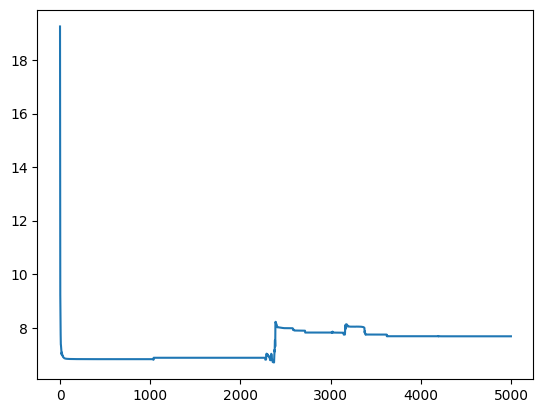

In [525]:
_ = plt.plot(losses)

In [527]:
result = probabilities.numpy()
arr0 = np.zeros(NCELLS).astype(object)

n = 0
s1 = np.argsort(result[n])[-K[n]:]
s2 = np.argsort(result[n])[:-K[n]]

arr0[s1] = "X"
arr0[s2] = " "
arr0 = arr0.reshape(BOARD_SIZE)

assign0 = torch.argmax(probabilities, dim=0).detach().numpy()
print (assign0.reshape(BOARD_SIZE))

print (SHAPES[n], SHAPES[n][0]*SHAPES[n][1], K[n], len(s1))
print (arr0)

T1s = torch.stack([getMin(probabilities[i, :], K[i]) for i in [n]])
print (T1s)
mask = (probabilities[n, :].numpy()>T1s.item()).reshape(BOARD_SIZE)
arr0[mask] = 'X'
arr0[~mask] = ' '
print (arr0)
T2 = 0.5
S1 = 100.
S2 = 5.
comp_loss = compactness_loss(probabilities[n, :].unsqueeze(0), BOARD_SIZE, [SHAPES[n]], T1s, S1, T2, S2, 0, verbose=True)
amount_loss = get_amount_loss(probabilities[n, :].unsqueeze(0), [K[n]], T1s, S1)
print (comp_loss, amount_loss)


[[3 1 0 0 2 0 2 0 3 3]
 [4 2 1 2 2 4 4 4 4 2]
 [3 4 4 0 4 4 4 0 4 3]
 [1 1 2 2 1 3 1 2 3 2]
 [3 3 0 0 2 0 3 2 3 3]
 [4 4 4 2 4 4 4 2 4 3]
 [1 1 4 2 4 4 2 1 2 0]
 [1 2 4 4 0 4 0 1 4 3]
 [3 3 2 4 3 3 3 4 4 1]
 [3 1 4 1 2 3 4 4 3 3]]
(5, 5) 25 tensor(25) 25
[[' ' ' ' 'X' 'X' ' ' 'X' ' ' 'X' ' ' ' ']
 [' ' 'X' 'X' 'X' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'X' ' ' ' ' ' ' 'X' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' 'X' 'X' 'X' ' ' 'X' ' ' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ' ' ' ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' ' ' 'X' ' ' 'X' 'X']
 [' ' ' ' ' ' ' ' 'X' ' ' 'X' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'X' ' ' ' ' 'X' 'X' ' ' ' ']]
tensor([0.4936])
[[' ' ' ' 'X' 'X' ' ' 'X' ' ' 'X' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'X' ' ' ' ' ' ' 'X' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' 'X' 'X' ' ' 'X' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '

In [1260]:
data = torch.randn(100)

Data sum -0.9689087867736816
Data avg -0.009689087979495525
Data span 4.910699844360352
e  2.71828
tensor([ 0.2940,  5.0090,  0.8850,  2.4367,  0.3734,  4.0135, 11.4558,  1.0716,
         0.9487,  0.4891,  0.3170,  1.0213,  0.6511,  0.5852,  0.6434,  4.6950,
         1.9216,  1.4166,  2.4909,  0.4250,  2.4028,  0.5811,  0.1690,  0.3956,
         1.5333,  1.2003,  0.2609,  1.5271,  2.4095,  0.3918,  1.6051,  3.1364,
         6.1607,  0.3685,  0.7392,  1.6748,  1.2543,  0.5398,  2.4191,  0.2435,
         0.1488,  0.7794,  0.5792,  1.1166,  1.8965,  1.1452,  0.4452,  0.3017,
         0.7410,  1.8880,  1.2718,  0.8680,  0.2929,  0.2812,  0.4603,  0.2112,
         0.2864,  4.4266,  0.4257,  0.1543,  1.2669,  0.8052, 11.2810,  0.4054,
         1.5832,  1.3719,  1.6186,  1.6603,  0.1750,  0.4694,  0.1759,  2.6190,
         1.2233, 20.1932,  0.4097,  1.9104,  2.6381,  0.2505,  0.5096,  0.5843,
         4.3491,  1.3524,  0.6942,  6.1504,  0.4512,  2.3681,  0.3538,  1.6643,
         1.6254,  0.7

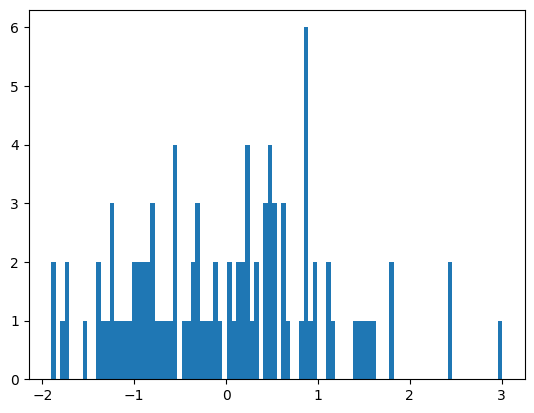

In [1274]:
#print (data)
print (f"Data sum {data.sum().item()}")
print (f"Data avg {data.mean().item()}")
print (f"Data span {data.max()-data.min()}")
print (f"e {np.e: 2.5f}")

data_e = torch.e ** data
print (data_e)
print (data_e / data_e.sum())
print (torch.softmax(data, dim=0))

_ = plt.hist(data, bins=len(data))

In [1286]:
def getSoftK(data, temperature, threshold, verbose=False):
    S1 = to.softmax(data / temperature, dim=0) # probabilities
    if verbose: print (S1)
    Sorted, _ = torch.sort(S1, dim=0, descending=True)
    if verbose: print (Sorted)
    C1 = torch.cumsum(Sorted, dim=0)
    if verbose: print (C1)
    S2 = torch.sigmoid((C1 - threshold) * 100)
    S2 = torch.abs(S2-1)
    if verbose: print (S2)
    soft_k = S2.sum()
    return soft_k + 1

K = 5.
j = data.size(0)
D1 = K - ((j**2) * data_e)
D2 = data_e.sum()
n = torch.sum(D1/D2)

print (n)
topMask = getTopKMask(data, a, n)
print (topMask.sum())
#print (getSoftK(data, temperature, threshold, True))

def getTopKMask(data, a, n):
    S1 = to.softmax(data, dim=0)
    S2 = (S1 * a**2) + n
    top_k_mask = torch.sigmoid(S2 * 1.)
    return top_k_mask

print ('topKMask')
for i in range(-int(data.size(0)/2)-1,int(data.size(0)/2)+1):
    a = data.size(0) 
    c = i 
    topMask = getTopKMask(data, a, c)
    #print (topMask)
    print (a, b, c, topMask.sum())



temperature = 10.
threshold = 0.5

"""
plt.figure(figsize=(5,5))

x_data = [i/1000. for i in range(100000, 1, -10)]
for threshold in range(10,0,-1):
    label = f"{threshold*10 : 2d}"
    y_data = [getSoftK(data, i/1000., threshold/10.).item() for i in range(100000, 1, -10)]
    plt.plot(x_data, y_data, label=label, linewidth=1.)

plt.xscale('log')
plt.yticks(list(range(11)))
plt.xticks([0.01,0.1,1.,10.,100.])
plt.xlabel("Temperature (SoftMax)")
plt.ylabel("Soft indexed items")
plt.grid(color='#CCCCCC', linestyle='-', linewidth=0.7, zorder=0)
plt.legend(fontsize=8, title="Threshold", labelspacing=0.4, title_fontsize=9)
plt.show()
"""


tensor(-9997.1475)
tensor(0.)
topKMask
100 10000 -51 tensor(53.2705)
100 10000 -50 tensor(53.8966)
100 10000 -49 tensor(54.4518)
100 10000 -48 tensor(54.8748)
100 10000 -47 tensor(55.2418)
100 10000 -46 tensor(55.6787)
100 10000 -45 tensor(56.2268)
100 10000 -44 tensor(56.8680)
100 10000 -43 tensor(57.6307)
100 10000 -42 tensor(58.5683)
100 10000 -41 tensor(59.6116)
100 10000 -40 tensor(60.6167)
100 10000 -39 tensor(61.4811)
100 10000 -38 tensor(62.2159)
100 10000 -37 tensor(62.9252)
100 10000 -36 tensor(63.6233)
100 10000 -35 tensor(64.3274)
100 10000 -34 tensor(65.2081)
100 10000 -33 tensor(66.3153)
100 10000 -32 tensor(67.3875)
100 10000 -31 tensor(68.2594)
100 10000 -30 tensor(69.0234)
100 10000 -29 tensor(69.8189)
100 10000 -28 tensor(70.7588)
100 10000 -27 tensor(71.9261)
100 10000 -26 tensor(73.3556)
100 10000 -25 tensor(74.9885)
100 10000 -24 tensor(76.7507)
100 10000 -23 tensor(78.5796)
100 10000 -22 tensor(80.3544)
100 10000 -21 tensor(81.9666)
100 10000 -20 tensor(83.4002)
1

'\nplt.figure(figsize=(5,5))\n\nx_data = [i/1000. for i in range(100000, 1, -10)]\nfor threshold in range(10,0,-1):\n    label = f"{threshold*10 : 2d}"\n    y_data = [getSoftK(data, i/1000., threshold/10.).item() for i in range(100000, 1, -10)]\n    plt.plot(x_data, y_data, label=label, linewidth=1.)\n\nplt.xscale(\'log\')\nplt.yticks(list(range(11)))\nplt.xticks([0.01,0.1,1.,10.,100.])\nplt.xlabel("Temperature (SoftMax)")\nplt.ylabel("Soft indexed items")\nplt.grid(color=\'#CCCCCC\', linestyle=\'-\', linewidth=0.7, zorder=0)\nplt.legend(fontsize=8, title="Threshold", labelspacing=0.4, title_fontsize=9)\nplt.show()\n'

In [1400]:
# Input data
data = torch.tensor([0.1, 0.6, 0.24, 0.12, 0.45])
print("Original data:", data)

# Compute pairwise differences
distances = data.unsqueeze(0) - data.unsqueeze(1)
print("Pairwise distances:\n", distances)

# Compute soft ranking using softmax over rows
sm1 = torch.softmax(distances / 0.1, dim=1)  # Negative sign to encourage ranking
print("Soft permutation matrix:\n", sm1)

# Compute soft sorted values
soft_sorted_data = sm1 @ data
print("Soft sorted data:\n", soft_sorted_data)

Original data: tensor([0.1000, 0.6000, 0.2400, 0.1200, 0.4500])
Pairwise distances:
 tensor([[ 0.0000,  0.5000,  0.1400,  0.0200,  0.3500],
        [-0.5000,  0.0000, -0.3600, -0.4800, -0.1500],
        [-0.1400,  0.3600,  0.0000, -0.1200,  0.2100],
        [-0.0200,  0.4800,  0.1200,  0.0000,  0.3300],
        [-0.3500,  0.1500, -0.2100, -0.3300,  0.0000]])
Soft permutation matrix:
 tensor([[0.0053, 0.7903, 0.0216, 0.0065, 0.1763],
        [0.0053, 0.7903, 0.0216, 0.0065, 0.1763],
        [0.0053, 0.7903, 0.0216, 0.0065, 0.1763],
        [0.0053, 0.7903, 0.0216, 0.0065, 0.1763],
        [0.0053, 0.7903, 0.0216, 0.0065, 0.1763]])
Soft sorted data:
 tensor([0.5600, 0.5600, 0.5600, 0.5600, 0.5600])


In [1624]:
data = torch.rand(20)

print (data)
print ('')
print ('sum', data.sum())
print ('')
print ('SoftMax')

sm = torch.softmax(data, dim=-1) * len(data) ** 2
print (sm, sm.sum())
temp = sm - (len(data) - 0.5)
print (temp, temp.sum())

print ('')
print ('Sigmoid')
sig = 1./(1. + (torch.e ** -(temp * 1.)))
print (sig, sig.sum(), data.sum() * torch.e)



tensor([0.3893, 0.6566, 0.8294, 0.3439, 0.2954, 0.6522, 0.5467, 0.2161, 0.9642,
        0.2672, 0.3302, 0.4980, 0.4238, 0.1478, 0.5290, 0.8497, 0.6590, 0.7930,
        0.1378, 0.8744])

sum tensor(10.4037)

SoftMax
tensor([17.0067, 22.2164, 26.4081, 16.2516, 15.4814, 22.1205, 19.9056, 14.3022,
        30.2192, 15.0508, 16.0303, 18.9598, 17.6025, 13.3579, 19.5549, 26.9500,
        22.2702, 25.4643, 13.2248, 27.6227]) tensor(400.0000)
tensor([-2.4933,  2.7164,  6.9081, -3.2484, -4.0186,  2.6205,  0.4056, -5.1978,
        10.7192, -4.4492, -3.4697, -0.5402, -1.8975, -6.1421,  0.0549,  7.4500,
         2.7702,  5.9643, -6.2752,  8.1227]) tensor(10.0000)

Sigmoid
tensor([0.0763, 0.9380, 0.9990, 0.0374, 0.0177, 0.9322, 0.6000, 0.0055, 1.0000,
        0.0116, 0.0302, 0.3682, 0.1304, 0.0021, 0.5137, 0.9994, 0.9410, 0.9974,
        0.0019, 0.9997]) tensor(9.6017) tensor(28.2801)


In [1698]:
import torch.nn.functional as F

def softsort(scores, tau=1.0):
    """
    Differentiable sorting using a soft permutation matrix.
    
    Args:
        scores (torch.Tensor): Input tensor of shape (batch_size, n), representing scores to be sorted.
        tau (float): Temperature parameter controlling the softness of the sorting.
        
    Returns:
        torch.Tensor: Approximate sorted values with the same shape as scores.
    """
    batch_size, n = scores.shape
    
    # Compute pairwise distances
    pairwise_diff = scores.unsqueeze(2) - scores.unsqueeze(1)  # Shape: (batch_size, n, n)
    
    # Compute soft permutation matrix using softmax
    P = F.softmax(-pairwise_diff / tau, dim=-1)  # Shape: (batch_size, n, n)
    
    # Compute sorted values
    sorted_scores = torch.matmul(P, scores.unsqueeze(-1)).squeeze(-1)  # Shape: (batch_size, n)
    
    return sorted_scores

# Example Usage
if __name__ == "__main__":
    scores = torch.tensor([[3.0, 1.0, 4.0, 1.5]], dtype=torch.float32)  # Example input
    tau = 10.  # Lower tau makes it closer to hard sorting
    sorted_scores = softsort(scores, tau=tau)
    print("Input scores:", scores)
    print("Soft-sorted scores:", sorted_scores)

Input scores: tensor([[3.0000, 1.0000, 4.0000, 1.5000]])
Soft-sorted scores: tensor([[2.5182, 2.5182, 2.5182, 2.5182]])


In [1708]:
from functions.pytorch_ops import soft_rank, soft_sort

In [1728]:
raw = list(range(10))
random.shuffle(raw)
data = torch.tensor(raw, dtype=torch.float32, requires_grad=True)
print (raw)

soft_sorted_data = soft_sort(data.unsqueeze(0), regularization_strength=50.0)
print (soft_sorted_data)
soft_sorted_data = soft_sort(data.unsqueeze(0), regularization_strength=5.0)
print (soft_sorted_data)
soft_sorted_data_2 = soft_sort(data.unsqueeze(0), regularization_strength=0.01)
print (soft_sorted_data_2)


[2, 5, 8, 4, 6, 0, 7, 1, 9, 3]
tensor([[4.4100, 4.4300, 4.4500, 4.4700, 4.4900, 4.5100, 4.5300, 4.5500, 4.5700,
         4.5900]], dtype=torch.float64, grad_fn=<StackBackward0>)
tensor([[3.6000, 3.8000, 4.0000, 4.2000, 4.4000, 4.6000, 4.8000, 5.0000, 5.2000,
         5.4000]], dtype=torch.float64, grad_fn=<StackBackward0>)
tensor([[-0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]], dtype=torch.float64,
       grad_fn=<StackBackward0>)
